# Cell counting

We will examine the use of U-Nets to perform cell counting, a crucial task to determine the number of cells in cell cultures before and after treatment.

## Cell nuclei images

We used image set BBBC039v1 Caicedo et al. 2018, available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012].

This data set has a total of 200 fields of view of nuclei captured with fluorescence microscopy using the Hoechst stain. The collection has around 23,000 single nuclei manually annotated to establish a ground truth collection for segmentation evaluation.

The images are stored as TIFF files with 520x696 pixels at 16 bits. Ground truth annotations are stored as PNG files encoding masks of independent nuclei.

https://data.broadinstitute.org/bbbc/BBBC039/

In [1]:
import os
import deeptrack as dt

raw_path = os.path.join("nuclei", "images")
label_path = os.path.join("nuclei", "masks")

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)

paths = dt.sources.Source(raw=raw_paths, label=label_paths)

sources = paths.product(flip_ud=[False], flip_lr=[False])

print(f"{len(sources)} images")

2024-01-29 00:34:12.072277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


200 images


We write a pipeline to load the images and the corresponding masks and display a few examples, with the corresponding histograms. 

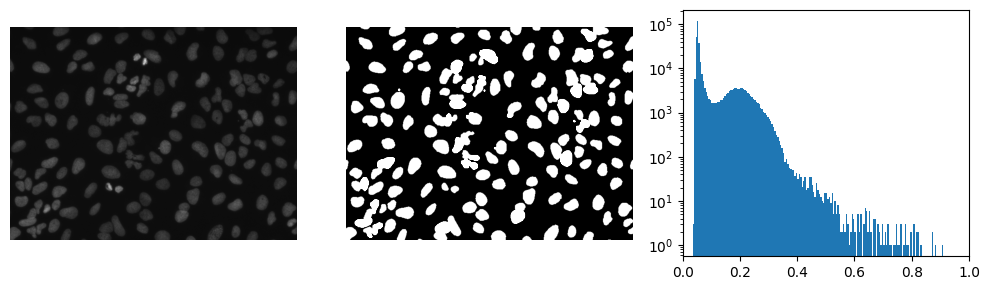

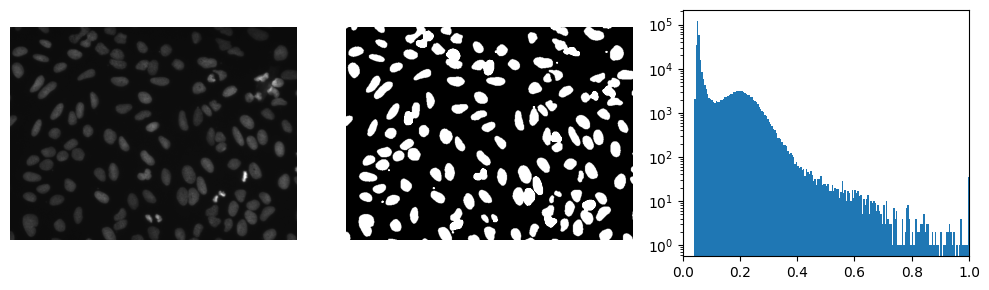

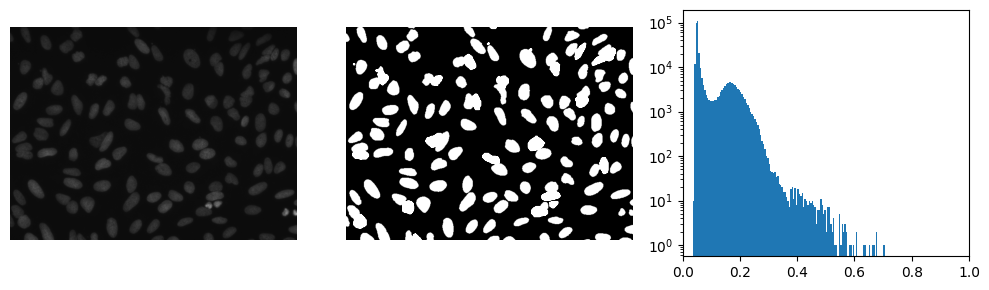

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader


im_pipeline = (
    dt.LoadImage(sources.raw.path)
    >> dt.Divide(3000)
    >> dt.Clip(0, 1)
    >> dt.AsType("float")
)

lab_pipeline = dt.LoadImage(sources.label.path)[:, :, 0:1] >> dt.AsType("float")

pipeline = (
    (im_pipeline & lab_pipeline)
    >> dt.Crop(crop=(512, 688, None), corner=(0, 0))
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

test_dataset = dt.pytorch.Dataset(pipeline, sources)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

idxs = np.random.choice(np.linspace(0, 199, 200).astype(int), 3, replace=False)
for i, idx in enumerate(idxs):
    image, mask = test_dataset[idx]
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.hist(np.array(image).flatten(), bins=200, range=(0, 1))
    plt.yscale("log")
    plt.xlim([0, 1])
    plt.tight_layout()
    plt.show()

To count the number of cells, we will use the number of connected components of the segmentaion mask, i.e. groups of adjacents pixels with the same value. 

For this, we can first _label_ the mask by assigning a different integer label to each component. We will verify it on the images we just displayed.

In [3]:
from skimage.morphology import label, area_closing, isotropic_erosion


def count_connected_components(mask):
    labeled_mask = label(mask)
    return labeled_mask.max()


for i, idx in enumerate(idxs):
    _, mask = test_dataset[idx]
    print("Number of cells = " + str(count_connected_components(mask)))

Number of cells = 165
Number of cells = 151
Number of cells = 141


## Simulations

We will use ``Deeptrack2.1`` to simulate fluorescently labeled cell nuclei, so to have a large labeled training dataset.

In [4]:
# # old

# training_image_size = 128


# def random_ellipse_radius():
#     desired_ellipse_area = (np.random.uniform(10, 30) * dt.units.pixel) ** 2
#     desired_radius_ratios = np.random.uniform(1, 4, size=2)
#     desired_radius_ratios /= np.sqrt(np.prod(desired_radius_ratios))
#     scale_factor = np.sqrt(desired_ellipse_area / np.pi)
#     radius = desired_radius_ratios * scale_factor
#     return radius


# ellipse = dt.Ellipse(
#     radius=random_ellipse_radius,
#     # intensity=lambda: np.random.uniform(0.01, 1.25),
#     intensity=lambda: np.random.uniform(0.01, 0.25),
#     position=lambda: np.random.uniform(5, training_image_size - 5, size=2),
#     rotation=lambda: np.random.uniform(0, 2 * np.pi),
# )

# optics = dt.Fluorescence(
#     resolution=1e-6,
#     magnification=10,
#     wavelength=400e-9,
#     NA=1.0,
#     output_region=(0, 0, training_image_size, training_image_size),
# )

# synthetic_cell = (
#     (ellipse ^ (lambda: np.random.randint(2, 10)))
#     >> dt.Pad(px=(5, 5, 5, 5))
#     >> dt.ElasticTransformation(alpha=50, sigma=8, order=1)
#     >> dt.CropTight()
#     >> dt.Poisson(snr=3)
# )

# # non_overlapping_cells = dt.NonOverlapping(synthetic_cell)
# # image_pipeline = (
# #     optics(non_overlapping_cells)
# #     >> dt.Multiply(4000)
# #     >> dt.Add(150)
# #     >> np.random.poisson
# #     >> dt.Divide(2000)
# #     >> dt.Clip(0, 1)
# # )


# non_overlapping_cells = dt.NonOverlapping(synthetic_cell)
# image_pipeline = (
#     optics(non_overlapping_cells)
#     >> dt.Add(lambda: np.random.uniform(0.01, 0.02))
#     >> dt.Multiply(lambda: np.random.uniform(4.5, 5.5))
#     >> dt.Poisson(snr=20)
#     >> dt.Clip(0, 1)
#     >> dt.AsType("float")
# )

In [5]:
training_image_size = 128


def random_ellipse_radius():
    desired_ellipse_area = (np.random.uniform(10, 35) * dt.units.pixel) ** 2
    desired_radius_ratios = np.random.uniform(1, 3.5, size=2)
    desired_radius_ratios /= np.sqrt(np.prod(desired_radius_ratios))
    scale_factor = np.sqrt(desired_ellipse_area / np.pi)
    radius = desired_radius_ratios * scale_factor
    return radius


ellipse = dt.Ellipse(
    radius=random_ellipse_radius,
    intensity=lambda: np.random.uniform(0.075, 0.5),
    position=lambda: np.random.uniform(5, training_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)

optics = dt.Fluorescence(
    resolution=1e-6,
    magnification=10,
    wavelength=400e-9,
    NA=1.0,
    output_region=(0, 0, training_image_size, training_image_size),
)

synthetic_cell = (
    (ellipse ^ (lambda: np.random.randint(4, 12)))
    >> dt.Pad(px=(10, 10, 10, 10))
    >> dt.ElasticTransformation(alpha=50, sigma=8, order=1)
    >> dt.CropTight()
    >> dt.Poisson(snr=3)
)

non_overlapping_cells = dt.NonOverlapping(synthetic_cell)
image_pipeline = (
    optics(non_overlapping_cells)
    >> dt.Add(lambda: np.random.uniform(0.005, 0.015))
    >> dt.Multiply(lambda: np.random.uniform(4.5, 5.5))
    >> dt.Poisson(snr=20)
    >> dt.AsType("float")
)

We also need to provide target images that will be used to quantify the number of cells. As a first approximation, we simply use the segmentation map. 


In [6]:
def fill_and_erode(radius=4, area=20, connectivity=1):
    def inner(mask):
        mask = np.array(mask.copy())
        mask = area_closing(
            mask.squeeze(), area_threshold=area, connectivity=connectivity
        )
        mask = isotropic_erosion(mask, radius=radius)
        mask = mask[:, :, np.newaxis]

        return mask

    return inner


label_pipeline = (
    non_overlapping_cells
    >> dt.SampleToMasks(
        lambda: lambda x: x > 0,
        output_region=optics.output_region,
        merge_method="or",
    )
    >> dt.Lambda(fill_and_erode)
    >> dt.AsType("float")
)

image_and_gt_pipeline = (
    (image_pipeline & label_pipeline)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

train_dataset = dt.pytorch.Dataset(image_and_gt_pipeline, length=640, replace=0.1)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

We display a few examples of simulated images with the corresponding masks and histograms.

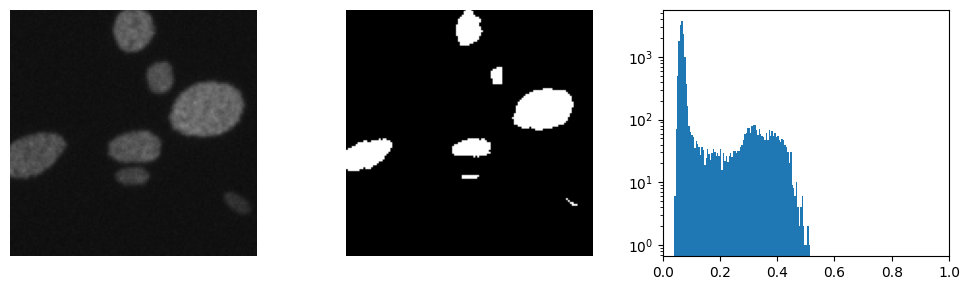

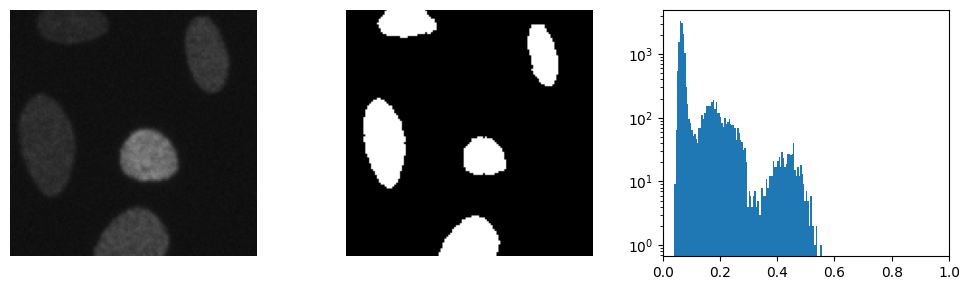

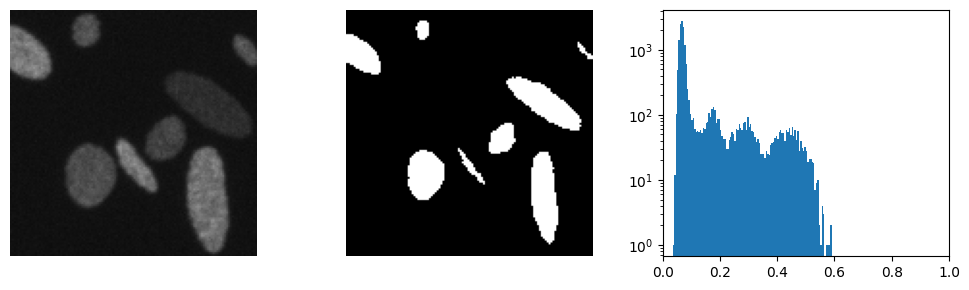

In [7]:
for i in range(3):
    image, mask = train_dataset[i]

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask.permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.hist(np.array(image).flatten(), bins=200, range=(0, 1))
    plt.xlim([0, 1])
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

## UNet

We will use a UNet to segment the cells.

In [8]:
import deeplay as dl

unet = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64, 128],
    out_channels=1,
)
print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool):

We use the binary crossentropy loss

In [9]:
import torchmetrics as tm
from torch.nn import BCEWithLogitsLoss

unet_regressor = dl.Regressor(
    model=unet,
    loss=BCEWithLogitsLoss(),
    optimizer=dl.Adam(),
).create()

We create the dataset and dataloaader to train the network for 30 epochs.

In [10]:
unet_trainer = dl.Trainer(max_epochs=50, accelerator="auto")

unet_trainer.fit(unet_regressor, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name   

Training: |          | 0/? [00:00<?, ?it/s]

Let's first test the network on the simulated data.

In [ ]:
for i in range(3):
    raw_image, mask = train_dataset[i]

    raw_image = raw_image.unsqueeze(0)
    pred = unet_regressor(raw_image).detach()
    pred = torch.nn.functional.sigmoid(pred)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(raw_image.squeeze(), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(pred.squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

We'll apply it to all the images in the test set and calculate true and predicted number of cells.

In [ ]:
images, labels, preds = [], [], []

for im, lab in test_loader:
    images.append(im)
    labels.append(lab)
    pr = unet_regressor(im).detach()
    pr = torch.nn.functional.sigmoid(pr)
    preds.append(pr)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)
true_count = [count_connected_components(l.squeeze()) for l in labels]
pred_count = [count_connected_components(p.squeeze() > 0.5) for p in preds]

We calculate MAE and MPE and display the results in a scatterplot.

In [ ]:
pred_count = np.array(pred_count)
true_count = np.array(true_count)
mae = abs(pred_count - true_count).mean()
nonzeros = true_count > 0
mpe = (abs(pred_count[nonzeros] - true_count[nonzeros]) / (true_count[nonzeros])).mean()
print(f"MAE: {mae:.2f}")
print(f"MPE: {mpe:.2f}")
plt.figure(figsize=(5, 5))
plt.scatter(true_count, pred_count, alpha=0.75)
plt.axline([0, 0], [1, 1], color="black")
plt.xlabel("True count")
plt.ylabel("Predicted count")
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()

...and check the predictions.

In [ ]:
i = 0

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(images[i].squeeze(), cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(labels[i].squeeze(), cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(preds[i].squeeze(), cmap="gray")
plt.axis("off")
plt.show()